# 20170601 Coding club Mini-Tutorial

Marvin Albert

How to break down your python code into small tasks and let a ‘scheduler’ take care of its execution


### Abstract
The goal of this mini-tutorial will be to become familiar with an intuitive and straight-forward way to define data analysis/processing pipelines in python, which

- structures code to keep it simple and reproducible
- manages our workflow and lets us focus on our pipeline’s goals
- provides automatic parallelisation on a laptop or cluster.

More specifically, we will identify the data dependencies of a given data processing pipeline and break it down into elementary tasks. This will lead to a graph representation of our problem in which
- nodes represent the data and intermediate results
- edges represent data dependencies and processing functions

Having defined such a graph in a simple python dictionary we will then use the python module dask to conveniently handle the execution, visualisation and parallelisation of our workflow.

# Motivation

## Pipelines
Generally speaking:
- a data analysis pipeline is a piece of software that computes a certain result from input data
- at its core lie the algorithms that define its computation/analysis
- however, it should also create reproducible results, be easily modifiable and run fast

Problems:
- in practice, at the time of writing/designing a pipeline, it's computation/analysis is not fully defined yet
- it therefore grows 'historically' making the code messy
 - difficult to understand
 - difficult to modify
 - difficult to optimise or run efficiently in parallel on a cluster

## Imperative vs functional programming
Often, a pipeline consists of a long list of steps the computer should perform in order to compute the result. In computer science, this is called the imperative (or algorithmic) approach. 

A different approach to structuring code is called functional programming. Here, computing a result is formulated as a set of functions that are executed.

Example:

In [ ]:
# input data
L = [1,2,3,4,5]

# imperative
result = 0
for x in L:
    result += x
print 'imperative sum: %s' %result

# functional
def add(x, y):
    return x + y
result = reduce(add, L)
print 'functional sum: %s' %result

Another example: (maybe find one with a changing state!)

In [51]:
# input data
naturalNumbers = [0,1,2,3,4,5,6,7]

# imperative
numbersAreEven = []
for x in naturalNumbers:
    if x % 2 == 0:
        numbersAreEven.append(True)
    else:
        numbersAreEven.append(False)
print 'imperative result: %s' %numbersAreEven
        
# functional
def evenNumber (x):
    return (x % 2) == 0
numbersAreEven = map(evenNumber, naturalNumbers)
print 'functional result: %s' %numbersAreEven

imperative result: [True, False, True, False, True, False, True, False]
functional result: [True, False, True, False, True, False, True, False]


Microsoft says:

| Characteristic | Imperative approach | Functional approach |
|----------|:-------------|:------|
| Programmer focus | How to perform tasks (algorithms) and how to track changes in state. | What information is desired and what transformations are required. |
| State changes | Important. | Non-existent.
|Order of execution | Important. | Low importance.
|Primary flow control | Loops, conditionals, and function (method) calls. | Function calls, including recursion.
|Primary manipulation unit | Instances of structures or classes. | Functions as first-class objects and data collections.



- one way to go is functional programming:
    - (example)
	- code execution doesn’t depend on the state of global variables
    - rather on clearly defined functions that are completely defined by their arguments
	- it’s a way to be transparent with the computer regarding the code's objective
    - the computer can automatically optimise / parallelise execution

However, pure functional programming can be a hassle and arbitrarily tricky.

This function calculates the set of all subsets of its argument:

In [26]:
f = lambda l: reduce(lambda z, x: z + [y + [x] for y in z], l, [[]])
print f([1,2,3,4,5])

[[], [1], [2], [1, 2], [3], [1, 3], [2, 3], [1, 2, 3], [4], [1, 4], [2, 4], [1, 2, 4], [3, 4], [1, 3, 4], [2, 3, 4], [1, 2, 3, 4], [5], [1, 5], [2, 5], [1, 2, 5], [3, 5], [1, 3, 5], [2, 3, 5], [1, 2, 3, 5], [4, 5], [1, 4, 5], [2, 4, 5], [1, 2, 4, 5], [3, 4, 5], [1, 3, 4, 5], [2, 3, 4, 5], [1, 2, 3, 4, 5]]


## Encoding workflow into graphs

Instead, let's have a look at an approach that borrows ideas from functional programming while remaining intuitive.

Main idea: Represent a pipeline as a graph

Nodes (rectangular) represent data, edges (round) represent functions
<img src="http://dask.pydata.org/en/latest/_images/pipeline.png",width=200>

We can use a python dictionary to define such a graph:

{'key1': value1, 'key2': value2 ...}

where the keys are the nodes of the graph and the values the edges, representing functions together with their arguments

In [23]:
def load(filename):
    ...
def clean(data):
    ...
def analyze(sequence_of_data):
    ...
def store(result):
    with open(..., 'w') as f:
        f.write(result)

dsk = {'load-1': (load, 'myfile.a.data'),
       'load-2': (load, 'myfile.b.data'),
       'load-3': (load, 'myfile.c.data'),
       'clean-1': (clean, 'load-1'),
       'clean-2': (clean, 'load-2'),
       'clean-3': (clean, 'load-3'),
       'analyze': (analyze, ['clean-%d' % i for i in [1, 2, 3]]),
       'store': (store, 'analyze')}

SyntaxError: invalid syntax (<ipython-input-23-be10fad281ba>, line 2)

### Example pipeline (image analysis)

Example pipeline:

- input: time series of a 2d nucleus
- output:
 - nucleus segmentation
 - size of the nucleus over time
 - center of mass of the nucleus over time

In [55]:
import os
from scipy import misc, ndimage
import numpy as np
%pylab inline
base_dir              = '/Users/malbert/Documents/meetings/CodingClub/20170518_dask_tutorial/data'
file_pattern          = os.path.join(base_dir,'yeastNucleus2DT%04d.tif')
out_file_pattern      = os.path.join(base_dir,'yeastNucleus2DT%04d_corrected.tif')
out_file_sizes        = os.path.join(base_dir,'nucleus_sizes.npy')
out_file_cms          = os.path.join(base_dir,'nucleus_cms.npy')
times                 = range(10)

Populating the interactive namespace from numpy and matplotlib


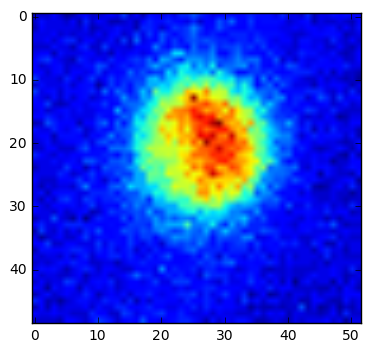

In [54]:
ims = [misc.imread(os.path.join(base_dir,'yeastNucleus2DT%04d.tif' %i)) for i in range(46)]
imshow(ims[45])

In [70]:
# imperative

def execute_pipeline():
    #segs  = []
    sizes          = []
    cms            = []
    for time in times:
        image            = misc.imread(file_pattern %time)
        background_level = np.percentile(image,5)
        seg              = image > background_level
        size             = np.sum(seg)
        cm               = np.array(seg.nonzero()).mean(1)
        sizes.append(size)
        cms.append(cm)

        misc.imsave(out_file_pattern %time, seg)

    np.save(out_file_sizes, size)
    np.save(out_file_cms, cms)
    return

# execute_pipeline()

In [57]:
# graph based
# the necessary functions:

def segment_nucleus(image):
    background_level = np.percentile(image,5)
    seg = image > background_level
    return seg

def calculate_cm(seg):
    return np.array(seg.nonzero()).mean(1)

def calculate_size(seg):
    return seg.sum()

# plus functions for reading and writing the images
# which already exist as misc.imread and misc.imsave

In [58]:
# the graph linking data and functions

graph = dict()
for time in times:
    graph['image_%04d'     % time] = (misc.imread, file_pattern % time)
    graph['seg_%04d'       % time] = (segment_nucleus, 'image_%04d' % time)
    graph['size_%04d'      % time] = (calculate_size,  'seg_%04d'   % time)
    graph['cm_%04d'        % time] = (calculate_cm,    'seg_%04d'   % time)
    graph['saved_seg_%04d' % time] = (misc.imsave, out_file_pattern % time, 'seg_%04d' % time)
    
graph['saved_sizes'] = (np.save, out_file_sizes, ['size_%04d' % time for time in times])
graph['saved_cms']   = (np.save, out_file_cms, ['cm_%04d' % time for time in times])

graph['all_results'] = ['saved_sizes','saved_cms'] + ['seg_%04d' % time for time in times]

## Using dask to evaluate the graph nodes

The dictionary _graph_ now contains all necessary information for executing the pipeline.

The python module _dask_ can take care of the execution.

First, we can visualize the graph

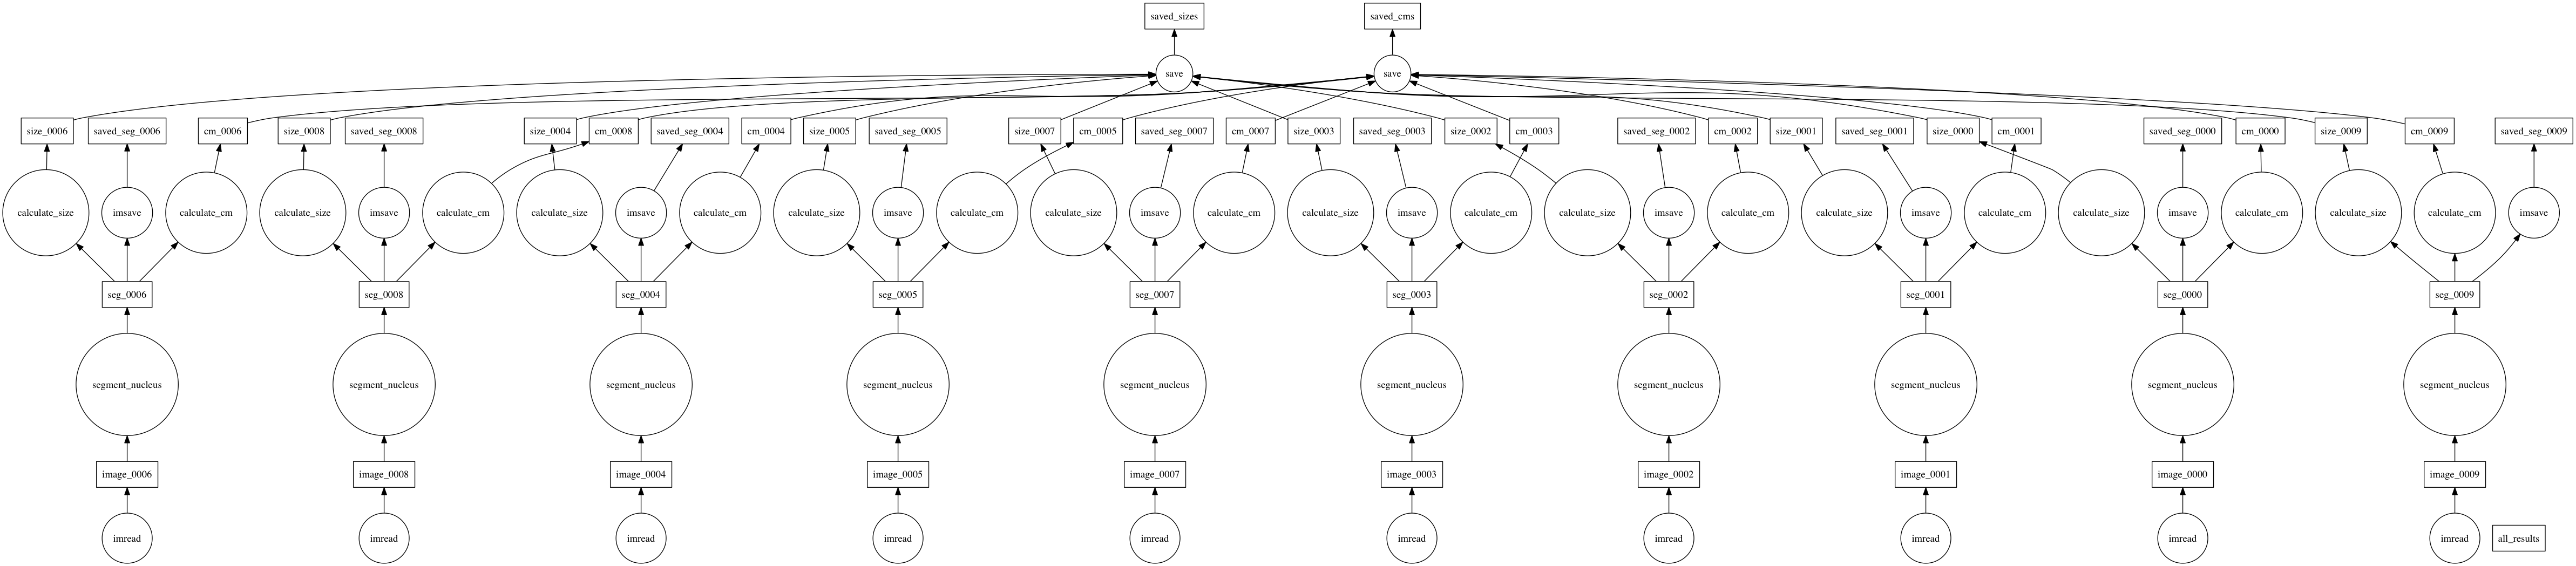

In [59]:
from dask.dot import dot_graph
dot_graph(graph)

And execution is easy:

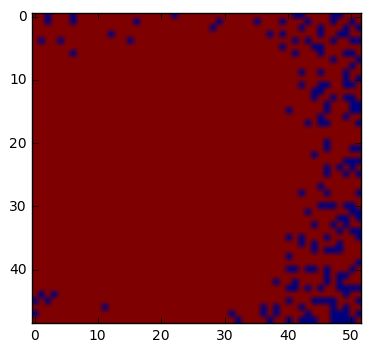

In [62]:
import dask
result = dask.get(graph, 'all_results')

seg_4 = dask.get(graph,'seg_0004')

imshow(seg_4)

#result = dask.threaded.get(graph, 'all_results')
#result = dask.multiprocessing.get(graph, 'all_results')

Graph execution looks like this:

https://github.com/dask/dask-tutorial/raw/7ddaa7e4ac356c12fed4828694dd4110645d5654/images/grid_search_schedule.gif

## Timing of both approaches

In [80]:
import time
from dask import multiprocessing

start = time.time()
dask.threaded.get(graph, 'all_results')
stop = time.time()
print 'graph execution took    %s seconds' %(stop - start)

start = time.time()
execute_pipeline()
stop = time.time()
print 'execution_pipeline took %s seconds' %(stop - start)

graph execution took    0.036514043808 seconds
execution_pipeline took 0.0657000541687 seconds


The graph execution is much faster because dask in the background automatically parallelises the execution of the functions on the individual nodes.

In [88]:
from dask.diagnostics import ProgressBar

with ProgressBar():
    result = dask.get(graph,'all_results')

[########################################] | 100% Completed |  0.1s


In [89]:
from dask.diagnostics import Profiler, ResourceProfiler
from dask.diagnostics import visualize

with Profiler() as prof, ResourceProfiler(dt=0.001) as rprof:#, CacheProfiler() as cprof:
    result = dask.threaded.get(graph,'all_results')
    
visualize([prof,rprof])

Column(id='7e74d7b2-4bf8-45ef-8b7a-978ad929ec3e', ...)

## Dask graphs and distributed computing

We call dask only after having built the graph in pure python:

In [ ]:
import dask
result = dask.get(graph, 'all_results')

Dask provides the _get_ function, which takes care of the execution.

Depending on what we need, dask provides several different such get functions:

<img src="https://s14-eu5.ixquick.com/cgi-bin/serveimage?url=http%3A%2F%2Fdask.pydata.org%2Fen%2Flatest%2F_images%2Fcollections-schedulers.png&sp=2c0f5b8039cef6f3003a9b274724bc1c">

Also, dask can create graphs by itself.

### Dask.distributed

A more general framework built on top of dask

<img src="http://dask.pydata.org/en/doc-test-build/_images/distributed-layout.png">

## Conclusion
There are many ways to build a pipeline: https://github.com/pditommaso/awesome-pipeline 